University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi

# Week 3 exercises

**General hints**:  
- **In order to estimate the accuracy of your answer**, it is recommended to run the sampler a few times and compute the standard deviation of the values you obtain. If the standard deviation of the values you obtain is smaller than the tolerance, the average of the values you obtain should be within the tolerance, assuming everything was done correctly.
- Monte Carlo error scales as $1/\sqrt{n}$ with the number of iterations $n$, i.e. you need to increase the number of iterations by a factor of 4 to cut the error in half.

In [2]:
from typing import Callable
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as integrate
from functools import partial
from typing import Any


plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 14

sns.set_style("whitegrid")


rng = np.random.default_rng(42)


## 1. Sampling a 1D distribution (4 points)

Write a Metropolis-Hastings sampler to sample from the (unnormalised) distribution
$$ P^*(\theta) = \cos^2(\theta) \exp(-|\theta|^3) $$
using a normal distribution with standard deviation $\sigma$ as the proposal
$q(\theta' ; \theta) = \mathcal{N}(\theta';\; \theta, \sigma^2)$.

1. Initialising the sampler at $\theta = 0$, draw 10000 samples with $\sigma=0.5$. Report the acceptance rate of the samples in Moodle.
2. Find a value of $\sigma$ that gives an acceptance rate close to the theoretically optimal value of $0.5$.
3. Evaluate $\mathbb{E}[\cos(\theta)]$, using samples drawn with the optimally tuned $\sigma$. Remember to throw out the warm-up samples! Report the value you obtain in Moodle.

The required tolerance for the answer is $\pm 0.03$.

*Hint*: It is useful to check your result by plotting a histogram of your samples and the target density (remembering it is unscaled).

In [47]:
# 1
def metropolis_hastings(theta0: np.ndarray, 
                        n: int, 
                        log_target: Callable[..., np.ndarray], 
                        proposal: Callable[[float, float, float], np.ndarray],
                        proposal_sigma: float = 1.0,
                        proposal_scalar: float = 1.0
                        ) -> tuple[np.ndarray, float]:
    theta = theta0
    samples = np.zeros(shape=(n, theta0.shape[0]))
    accepts = 0
    for i in range(n):
        theta_prop = proposal(theta, proposal_scalar, proposal_sigma)
        u = rng.uniform(size=theta0.shape[0])
        if (np.log(u) < log_target(theta_prop) - log_target(theta)).all():
            breakpoint()
            theta = theta_prop
            accepts += 1
        samples[i] = theta
    return samples, accepts / n



/tmp/ipykernel_5491/178652009.py:3: RuntimeWarning: invalid value encountered in log
  log_target = lambda theta: np.array([np.log(2 * np.cos(theta)) + ( -np.abs(theta)**3)])


Acceptance rate: 0.5328


/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/vir

<Axes: ylabel='Density'>

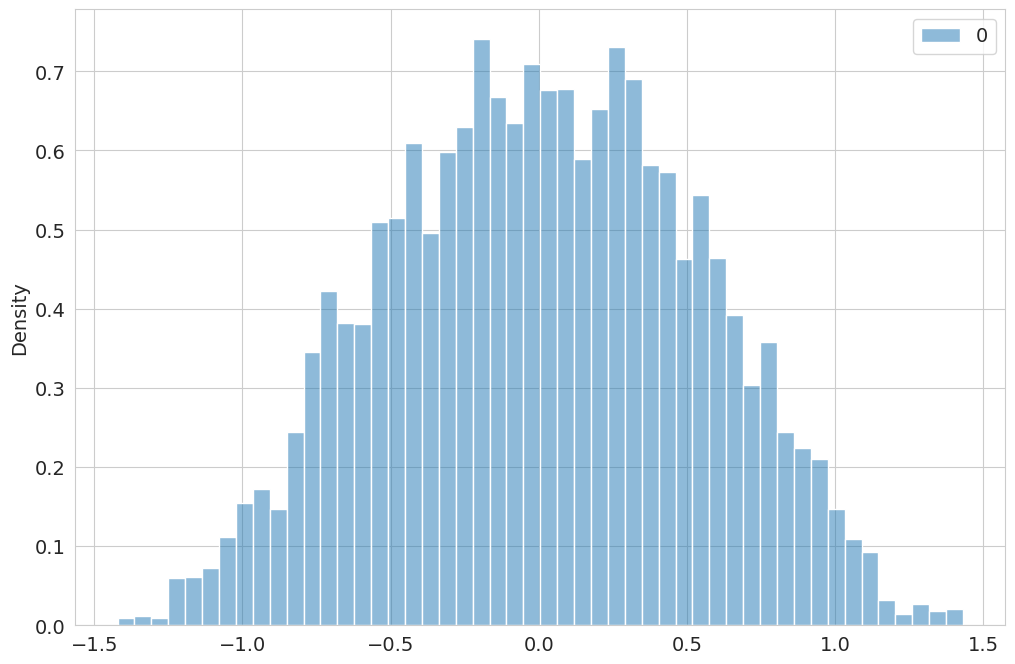

In [48]:

sd = 0.5
n = 10000
log_target = lambda theta: np.array([np.log(2 * np.cos(theta)) + ( -np.abs(theta)**3)])
proposal = lambda theta, scalar, sigma: np.array([ scalar * stats.norm(theta, sigma**2).rvs()])

samples, acceptance_rate = metropolis_hastings(np.array([0.0]), n, log_target, proposal, proposal_scalar=1)
print(f"Acceptance rate: {acceptance_rate}")

sns.histplot(samples, stat="density", bins=50)

In [49]:
# 2

# let's use a halfnormal to try and find appropriate values for sigma
def optimize_sigma_halfnorm(
        mcmc: Callable[..., tuple[np.ndarray, float]],
        sigma_hyperprior: float,
        n_iterations: 100,
        n_dim: int = 1,
        target_accept: float = .5,
        eps: float = 0.05
) -> float:
    
    sigma_candidates = stats.halfnorm(scale=sigma_hyperprior).rvs(n_iterations)
    acceptance_rates = np.zeros(n_iterations)
    best_acceptance_rate_diff = np.inf
    best_sigma = None
    for i in range(n_iterations):
        s = np.eye(n_dim) * sigma_candidates[i]
        breakpoint()
        _, acceptance_rate = mcmc(proposal_sigma=s)
        acceptance_rates[i] = acceptance_rate
        acceptance_diff = np.abs(target_accept - acceptance_rate)
        if acceptance_diff < best_acceptance_rate_diff:
            best_acceptance_rate_diff = acceptance_diff
            best_sigma = s
            print(f"New sigma: {best_sigma} - acceptance rate: {acceptance_rate}")
        if target_accept - eps < acceptance_rate < target_accept + eps:
            breakpoint()
            print(f"Converged at iteration {i}")
            return best_sigma
    return best_sigma


In [50]:

opt_sigma = optimize_sigma_halfnorm(
    partial(metropolis_hastings, theta0=np.array([0.0]), n=10000, log_target=log_target, proposal=proposal),
    sigma_hyperprior=1,
    n_iterations=50,
    target_accept=.5,
    eps = .01
    )
print(f"Optimal sigma: {opt_sigma}")

New sigma: [[0.21102168]] - acceptance rate: 0.9778


/tmp/ipykernel_5491/178652009.py:3: RuntimeWarning: invalid value encountered in log
  log_target = lambda theta: np.array([np.log(2 * np.cos(theta)) + ( -np.abs(theta)**3)])


New sigma: [[1.90325305]] - acceptance rate: 0.1817
New sigma: [[0.62297374]] - acceptance rate: 0.7894
New sigma: [[0.69265018]] - acceptance rate: 0.7447
New sigma: [[1.53274812]] - acceptance rate: 0.2725
New sigma: [[1.04614021]] - acceptance rate: 0.4987
Converged at iteration 13
Optimal sigma: [[1.04614021]]


In [51]:
e_cos_results = np.zeros(5)
n = 25000
for i in range(len(e_cos_results)):
    samples, acceptance_rate = metropolis_hastings(np.array([0.0]), n, log_target, proposal, proposal_sigma=opt_sigma)
    _, valid_samples = samples[:n//2], samples[n//2:]
    y = np.mean(np.cos(valid_samples))
    e_cos_results[i] = y


/tmp/ipykernel_5491/178652009.py:3: RuntimeWarning: invalid value encountered in log
  log_target = lambda theta: np.array([np.log(2 * np.cos(theta)) + ( -np.abs(theta)**3)])


/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/vir

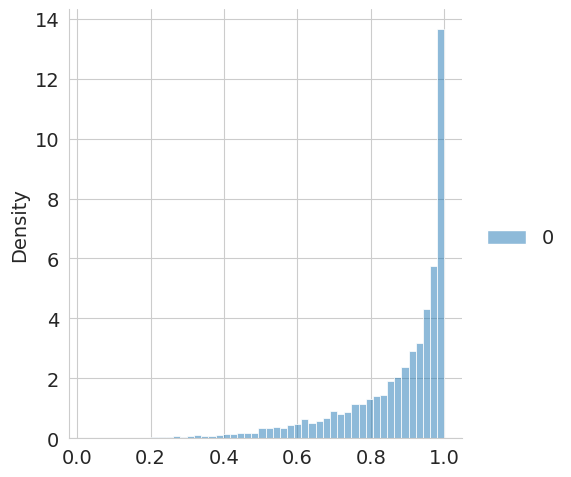

In [52]:
sns.displot(np.cos(valid_samples), stat="density", bins=50)

In [53]:
print(e_cos_results.std(), e_cos_results.mean())

0.0025844397294153285 0.8718382476742391


## 2. Sampling a 2D distribution (4 points)

Write a Metropolis-Hastings sampler to evaluate the following expectations over the given (unnormalised) distributions using a suitably scaled multivariate normal distribution with diagonal covariance as the proposal.

1. $E[\theta_1^2 + \theta_2^2]$, when $P^*(\boldsymbol{\theta}) = \exp\left(-3(\sqrt{(\theta_1-\mu_1)^2 + (\theta_2-\mu_2)^2} - r^2)^2 \right)$.
2. $E[\theta_1^2 + \theta_2^2]$, when $P^*(\boldsymbol{\theta}) = \exp\left(-3(\sqrt{(\theta_1-\mu_1)^2 + (\theta_2-\mu_2)^2} - r^2)^2 + |2\theta_1 - \theta_2|\right)$.

Here $\mu_1 = 1, \mu_2 = 2$ and $r = \sqrt{2}$.

The required tolerance for the answer is $\pm 0.3$.

*Hint*: It is useful to check your result by plotting a scatter plot of your samples and a contour plot of the logarithm of the target function. Remember to throw out the warm-up samples!

In [54]:
mu_1 = 1
mu_2 = 2
r = np.sqrt(2)

# 2.1
log_target = lambda theta: -3 * ( np.sqrt( (theta[0] - mu_1)**2 + (theta[1] - mu_2)**2) - r **2 ) **2
proposal = lambda theta, scalar, sigma: scalar * stats.multivariate_normal(theta, sigma**2).rvs()

opt_sigma = optimize_sigma_halfnorm(
    partial(metropolis_hastings, theta0=np.array([0.0, 0.0]), n=10000, log_target=log_target, proposal=proposal),
    n_iterations=50,
    sigma_hyperprior=1,
    n_dim=2,
    eps=.01
    )
print(f"Optimal sigma: {opt_sigma}")

New sigma: [[0.52827341 0.        ]
 [0.         0.52827341]] - acceptance rate: 0.5269
New sigma: [[0.52649841 0.        ]
 [0.         0.52649841]] - acceptance rate: 0.5242
New sigma: [[0.57796871 0.        ]
 [0.         0.57796871]] - acceptance rate: 0.5031
Converged at iteration 15
Optimal sigma: [[0.57796871 0.        ]
 [0.         0.57796871]]


0.41705767192964616 9.213080888285532


/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/vir

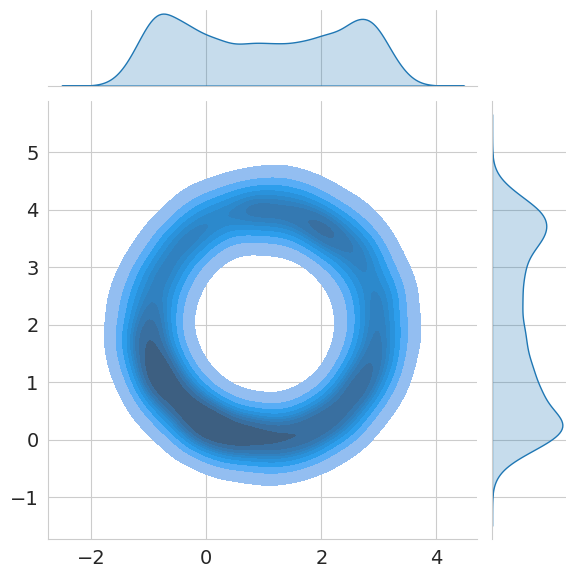

In [55]:
n = 50_000
e_xsq_plus_ysq_results = np.zeros(10)
for i in range(len(e_xsq_plus_ysq_results)):
    samples, _ = metropolis_hastings(np.array([0.0, 0.0]), n, log_target, proposal, proposal_sigma=opt_sigma)
    _, valid_samples = samples[:n//2], samples[n//2:]
    y = np.mean(valid_samples[:, 0] ** 2 + valid_samples[:, 1] ** 2)
    e_xsq_plus_ysq_results[i] = y
print(e_xsq_plus_ysq_results.std(), e_xsq_plus_ysq_results.mean())
sns.jointplot(x=samples[n//2:, 0], y=samples[n//2:, 1], kind="kde", fill=True)
del(n)

In [60]:
# 2.2
n = 50_000
log_target = lambda theta:  -3 * ( np.sqrt( (theta[0] - mu_1)**2 + (theta[1] - mu_2)**2) - r **2 ) **2 + np.abs(2*theta[0] - theta[1])


opt_sigma = optimize_sigma_halfnorm(
        partial(metropolis_hastings, theta0=np.array([0.0, 0.0]), n=10000, log_target=log_target, proposal=proposal),
        n_iterations=50,
        sigma_hyperprior=1,
        n_dim=2,
        eps=.01
    )
print(f"Optimal sigma: {opt_sigma}")

New sigma: [[1.24086871 0.        ]
 [0.         1.24086871]] - acceptance rate: 0.185
New sigma: [[0.87683837 0.        ]
 [0.         0.87683837]] - acceptance rate: 0.2821
New sigma: [[0.70469512 0.        ]
 [0.         0.70469512]] - acceptance rate: 0.356
New sigma: [[0.33791283 0.        ]
 [0.         0.33791283]] - acceptance rate: 0.6084
New sigma: [[0.45347612 0.        ]
 [0.         0.45347612]] - acceptance rate: 0.5124
New sigma: [[0.49245615 0.        ]
 [0.         0.49245615]] - acceptance rate: 0.4879
Optimal sigma: [[0.49245615 0.        ]
 [0.         0.49245615]]


In [61]:
e_xsq_plus_ysq_results_2 = np.zeros(10)
for i in range(len(e_xsq_plus_ysq_results_2)):
    samples, acceptance_rate = metropolis_hastings(np.array([0.0, 0.0]), n, log_target, proposal, proposal_sigma=opt_sigma)
    _, valid_samples = samples[:n//2], samples[n//2:]
    y = np.mean(valid_samples[:, 0] ** 2 + valid_samples[:, 1] ** 2)
    e_xsq_plus_ysq_results_2[i] = y


0.13161684905432824 10.849037555375016
[10.88201978 10.76631596 10.99417849 11.06014285 10.97107112 10.91031009
 10.73798917 10.75998908 10.80111332 10.60724569]


/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/virtualenvs/computational-statistics-qlF0ErcH-py3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/sjack/.cache/pypoetry/vir

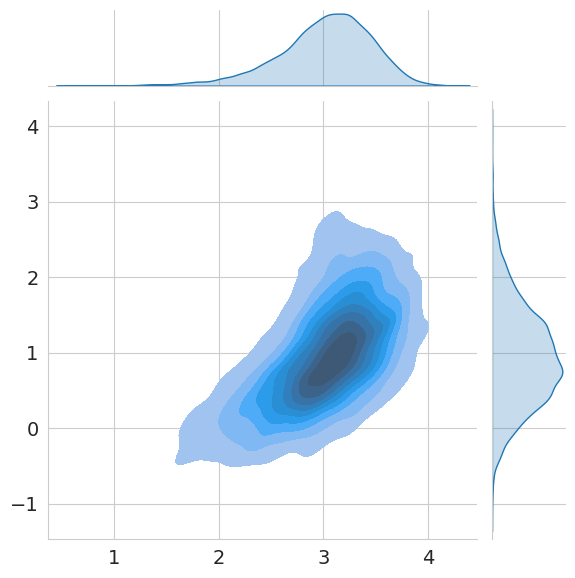

In [62]:
print(e_xsq_plus_ysq_results_2.std(), e_xsq_plus_ysq_results_2.mean())
print(e_xsq_plus_ysq_results_2)

sns.jointplot(x=samples[n//2:, 0], y=samples[n//2:, 1], kind="kde", fill=True)
del(n)

In [63]:
np.median(e_xsq_plus_ysq_results_2)

10.841566549996163

## 3. MCMC sampling for the posterior of the mean of the Student-t distribution (6 points)

In this exercise we will use MCMC to sample the posterior distribution over the location (or mean) parameter $\mu$ of [Student's $t$-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) for a set of data points $X = (x_i)_{i=1}^n$ that are assumed to be conditionally independent given $\mu$, i.e.
$$ p(X | \mu) = \prod_{i=1}^n p(x_i | \mu), $$
where $p(x_i | \mu)$ is the Student's $t$-distribution centred at $\mu$ with $\nu = 5$ degrees of freedom.

Using the data loaded in the below code as $X$,
write a Metropolis-Hastings sampler to draw samples from $p(\mu | X)$ when the prior $p(\mu)$ is as follows, and return the required posterior statistics to Moodle.

1. $p(\mu) = \mathcal{N}(\mu;\; 0, 1^2)$. Report the posterior mean and standard deviation of $\mu$, i.e. mean and standard deviation of $p(\mu | X)$ estimated from the Monte Carlo samples to Moodle.
2. $p(\mu) = \mathrm{Uniform}(\mu;\; -5, 5)$. Report the posterior mean and standard deviation of $\mu$, i.e. mean and standard deviation of $p(\mu | X)$ estimated from the Monte Carlo samples to Moodle.

The require tolerance is $\pm 0.03$.

*Hints*: 
- Please see Chapter 7 of the course notes for more background. 
- You can evaluate the log-pdf of the Student's $t$-distribution using `scipy.stats.t.logpdf()`.
- You can compute posterior mean and standard deviation directly as the mean and standard deviation of your samples. 
- A suitably scaled normal distribution centred at the current point should be a good proposal.
- Remember to throw out the warm-up samples!

In [64]:
import numpy as np
import numpy.random as npr
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/toydata2.txt', sep='\t', header=None)
data = data.values
data = np.array(data[:,0])

In [66]:

# 3.1
log_prior = lambda mu: np.sum(stats.norm(0, 1**2).logpdf(mu))
log_likelihood = lambda mu: np.sum(stats.t(df=5).logpdf(data - mu))
log_posterior = lambda mu: log_likelihood(mu) + log_prior(mu)
proposal = lambda theta, scalar, sigma: scalar * stats.norm(theta, sigma**2).rvs()

#this code takes too long to run
# opt_sigma = optimize_sigma_halfnorm(
#     mcmc=partial(metropolis_hastings, theta0=np.array([0]), n=10000, log_target=log_posterior, proposal=proposal),
#     sigma_hyperprior=1,
#     n_iterations=50,
#     target_accept=.5,
#     eps = .01
#     )
# print(f"Optimal sigma: {opt_sigma}")

opt_sigma = 0.57364846

In [67]:
n = 50_000

results = []
for i in range(3):
    samples, acceptance_rate = metropolis_hastings(theta0=np.array([1.0]), 
                                                n=n, 
                                                log_target=log_posterior, 
                                                proposal=proposal,
                                                proposal_sigma=opt_sigma)
    results.append(samples[n//2:])
    print(f"Acceptance rate: {acceptance_rate}")

Acceptance rate: 0.53032
Acceptance rate: 0.52938
Acceptance rate: 0.52942


In [68]:
print(np.array(results).mean(axis=1).std(), np.median(np.array(results).mean(axis=1)))

0.00362479158762443 3.8101262863408016


In [69]:
np.median(np.array(results).std(axis=1))

0.18249822157892368

In [70]:

# 3.2
n=50_000
log_prior = lambda mu: np.sum(stats.uniform(-5, 10).logpdf(mu))
log_posterior = lambda mu: log_likelihood(mu) + log_prior(mu)

opt_sigma = optimize_sigma_halfnorm(
    mcmc=partial(metropolis_hastings, theta0=np.array([0]), n=10000, log_target=log_posterior, proposal=proposal),
    sigma_hyperprior=1,
    n_iterations=25,
    target_accept=.5,
    eps = .01
)
print(f"Optimal sigma: {opt_sigma}")







New sigma: [[0.48544461]] - acceptance rate: 0.6363
New sigma: [[0.50829644]] - acceptance rate: 0.6037
New sigma: [[0.71215093]] - acceptance rate: 0.4015
New sigma: [[0.68590528]] - acceptance rate: 0.4245
Optimal sigma: [[0.68590528]]


In [72]:
samples, results = None, None
results = []
n=50_000

for i in range(3):
    samples, acceptance_rate = metropolis_hastings(theta0=np.array([0]), 
                                                n=n, 
                                                log_target=log_posterior, 
                                                proposal=proposal,
                                                proposal_sigma=.65,
    )
    results.append(samples[n//2:])
    print(f"Acceptance rate: {acceptance_rate}")


Acceptance rate: 0.45076
Acceptance rate: 0.45294
Acceptance rate: 0.4538


In [73]:
rr = np.array(results)

In [74]:
rr.mean(axis=1).std()

0.0025802052171569126

In [75]:
np.median(rr.mean(axis=1))

3.9418914003414334

In [76]:
np.median(rr.std(axis=1))

0.18272044073744367

(array([2.000e+00, 0.000e+00, 0.000e+00, 1.100e+01, 6.000e+00, 1.100e+01,
        9.000e+00, 2.600e+01, 2.800e+01, 5.600e+01, 7.300e+01, 1.060e+02,
        1.400e+02, 1.920e+02, 3.080e+02, 3.410e+02, 4.440e+02, 5.370e+02,
        6.960e+02, 8.850e+02, 1.049e+03, 1.191e+03, 1.203e+03, 1.448e+03,
        1.449e+03, 1.501e+03, 1.543e+03, 1.613e+03, 1.545e+03, 1.401e+03,
        1.241e+03, 1.153e+03, 9.320e+02, 8.150e+02, 6.810e+02, 5.650e+02,
        4.700e+02, 3.510e+02, 2.850e+02, 2.160e+02, 1.760e+02, 1.060e+02,
        6.400e+01, 5.300e+01, 3.600e+01, 9.000e+00, 1.800e+01, 3.000e+00,
        1.100e+01, 1.000e+00]),
 array([3.19141823, 3.21976535, 3.24811246, 3.27645958, 3.3048067 ,
        3.33315382, 3.36150094, 3.38984806, 3.41819518, 3.4465423 ,
        3.47488942, 3.50323654, 3.53158366, 3.55993078, 3.5882779 ,
        3.61662502, 3.64497214, 3.67331926, 3.70166638, 3.7300135 ,
        3.75836062, 3.78670774, 3.81505486, 3.84340198, 3.8717491 ,
        3.90009621, 3.92844333, 3.95

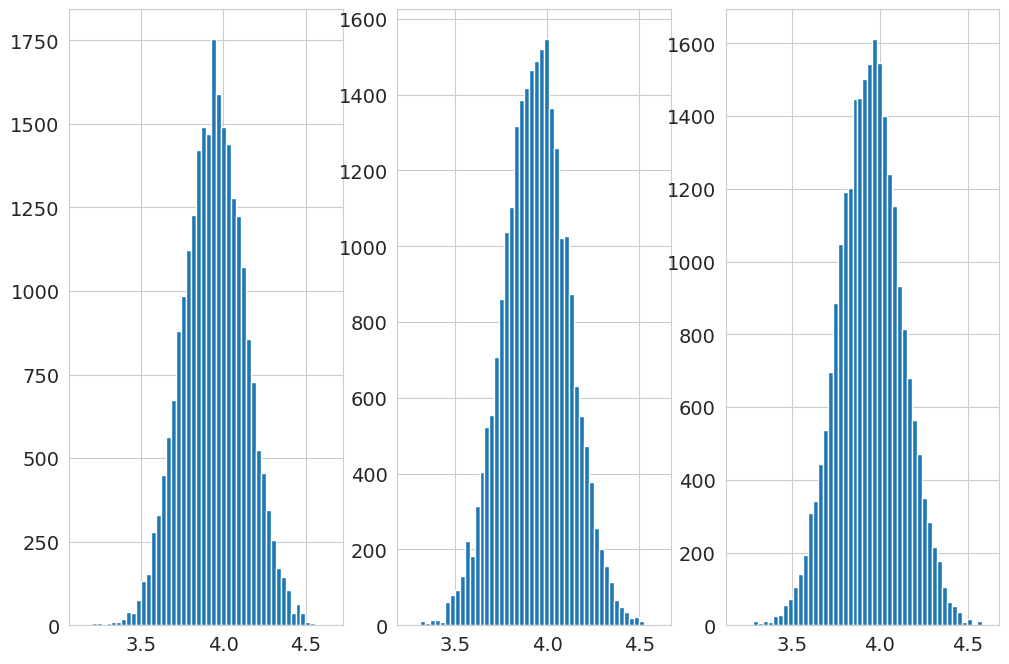

In [86]:
fig, ax = plt.subplots(1, 3)
ax[0].hist(rr[0], bins=50)
ax[1].hist(rr[1], bins=50)
ax[2].hist(rr[2], bins=50)

## 4. MCMC sampling for the posterior of gamma distribution parameters (6 points)

In this exercise we test Bayesian estimation of the parameters $\alpha, \beta$ of the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) for a given data set. We will use the shape/rate parametrisation of the gamma distribution. Under this parametrisation, the probability density function of the gamma distribution is
$$ p(x) = \mathrm{Gamma}(x;\; \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{\alpha-1} \exp(-\beta x), \quad \alpha,\beta > 0,$$
where $\Gamma(x)$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function).

The prior distributions of the parameters $\alpha$ and $\beta$ are
$$ p(\alpha) = \mathrm{Gamma}\left(\frac{1}{2}, \frac{1}{2}\right), \quad p(\beta) = \mathrm{Gamma}\left(\frac{1}{2}, \frac{1}{2}\right), $$
and we assume a factorized prior, i.e. $$p(\alpha, \beta) = p(\alpha) p(\beta).$$

Please remember that the Gamma distribution has the additional constraint that its parameters $\alpha$ and $\beta$ need to be positive. This can be accomplised by parametrising using new unconstrained variables $a,b$ with $\alpha = \exp(a)$ and $\beta = \exp(b)$.

1. Load the data set $\mathcal{D} = \{ x_i | i = 1, \dots, n \}$ using the function below.
2. Implement the log-probability density function of the gamma distribution. Report the value of the log-probability density $\ln p(\alpha)$ at $\alpha = 1$.
3. Transform the prior probability densities of $\alpha$ and $\beta$ to distributions over unbounded variables $a, b$. Report the log-density value $\ln p(a)$ evaluated at $a=1$ in Moodle. (*Hint*: See Sec. 7.3.3. in the course notes!)
4. Sample from the posterior $$p(a, b | \mathcal{D}) \propto p(\mathcal{D}| a, b) p(a) p(b) = \left[\prod_{i=1}^n \text{Gamma}(x_i; \exp(a), \exp(b))\right] p(a) p(b)$$ using a Metropolis-Hastings sampler. *Note*: The symbol $\propto$ means "proportional to", since we omitted the normalization constant $p(\mathcal{D})$ in the denominator of Bayes' theorem. We can do this since Metropolis-Hastings (as most MCMC samplers) does not need the target density to be normalized.
5. Transform the values of $a,b$ back to $\alpha, \beta$ and report the posterior means and standard deviations (`np.mean(alpha_samples)`, `np.std(alpha_samples)`, `np.mean(beta_samples)`, `np.std(beta_samples)`) for $\alpha$ and $\beta$ in Moodle.

The required tolerance for the posterior statistics is $\pm 0.1$.

*Hints*: 
- You can check your implementations of the probability density functions by making sure they are properly normalised using e.g. `scipy.integrate.quad()`. 
- A multivariate normal distribution centred at the current point should be a good proposal. Remember to throw out the warm-up samples!
- As a help, we already provide an implementation of the log pdf of the gamma distribution.

In [96]:
import numpy as np
import pandas as pd
import scipy.special as scs

# 1 load dataset

data1 = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/toydata.txt', sep='\t', header=None)
data1 = data1.values
data1 = np.array(data1[:,0])

# 2

def gamma_logpdf(x, alpha, beta):
    """Log pdf of the gamma distribution with shape/rate parameters alpha and beta."""
    return (alpha*np.log(beta) - scs.gammaln(alpha) + (alpha-1) * np.log(x) - beta * x)

# 3

log_alpha_prior = lambda alpha: gamma_logpdf(alpha, .5, .5)
log_beta_prior = lambda beta: gamma_logpdf(beta, .5, .5)
log_a_prior = lambda a: gamma_logpdf(np.exp(a), .5, .5) * a
log_b_prior = lambda b: gamma_logpdf(np.exp(b), .5, .5) * b
log_prior = lambda alpha, beta: log_alpha_prior(alpha) + log_beta_prior(beta)
log_likelihood = lambda alpha, beta: gamma_logpdf(data1, np.exp(alpha), np.exp(beta))
log_posterior = lambda theta: np.sum(log_prior(theta[0], theta[1]) + log_likelihood(theta[0], theta[1]))
print(log_alpha_prior(1))
print(log_phi_prior(1,))


-1.4189385332046727


TypeError: <lambda>() missing 1 required positional argument: 'phi_beta'

In [ ]:
proposal = lambda theta, sigma: stats.multivariate_normal(theta, sigma**2).rvs()
if False:
    opt_sigma = optimize_sigma_halfnorm(
        mcmc=partial(metropolis_hastings, theta0=np.array([0, 0]), n=1000, log_target=log_posterior, proposal=proposal),
        sigma_hyperprior=2,
        n_iterations=50,
        n_dim=2,
    )
else:
    opt_sigma = np.array([[0.19673212,0.        ], [0., 0.19673212]])



In [ ]:
results = []
for i in range(5):
    samples, acceptance_rate = metropolis_hastings(
    theta0=np.array([0, 0]),
    n=25000,
    log_target=log_posterior,
    proposal=proposal,
    proposal_sigma=opt_sigma,
    )
    results.append(samples[12500:])
    print(f"Acceptance rate: {acceptance_rate}")


In [ ]:
np.median(np.exp(np.array(results)).mean(axis=1), axis=0)